In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import year, col
from pyspark.sql.types import FloatType

# Initialize Spark Session
spark = SparkSession.builder.appName("MoviesClustering").getOrCreate()

# Load data
data = spark.read.csv('movies.csv', inferSchema=True, header=True)

# Convert string columns to float
data = data.withColumn("popularity", col("popularity").cast(FloatType())) \
           .withColumn("vote_average", col("vote_average").cast(FloatType())) \
           .withColumn("vote_count", col("vote_count").cast(FloatType()))

# Convert release_date to year and keep only relevant columns
data = data.withColumn("release_year", year("release_date")) \
           .select("popularity", "vote_average", "vote_count", "release_year")

# Handle missing values if necessary
data = data.na.drop()

# Assemble features
assembler = VectorAssembler(inputCols=["popularity", "vote_average", "vote_count", "release_year"], outputCol="features")
dataset = assembler.transform(data)

# K-means model
kmeans = KMeans().setK(5).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


23/12/11 23:56:11 WARN Utils: Your hostname, Hadis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.83.92.176 instead (on interface en0)
23/12/11 23:56:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 23:56:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/11 23:56:21 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Silhouette with squared euclidean distance = 0.836257838752329
Cluster Centers: 
[  25.04283879    6.5404782   737.53546727 2003.44506997]
[7.49233277e+01 7.42115544e+00 1.18978193e+04 2.00720168e+03]
[1.18972037e+02 7.72407317e+00 2.06286220e+04 2.00853659e+03]
[  43.88200651    6.75481394 2883.49066092 2005.93534483]
[  67.49523721    6.97501604 6391.32798574 2007.8057041 ]


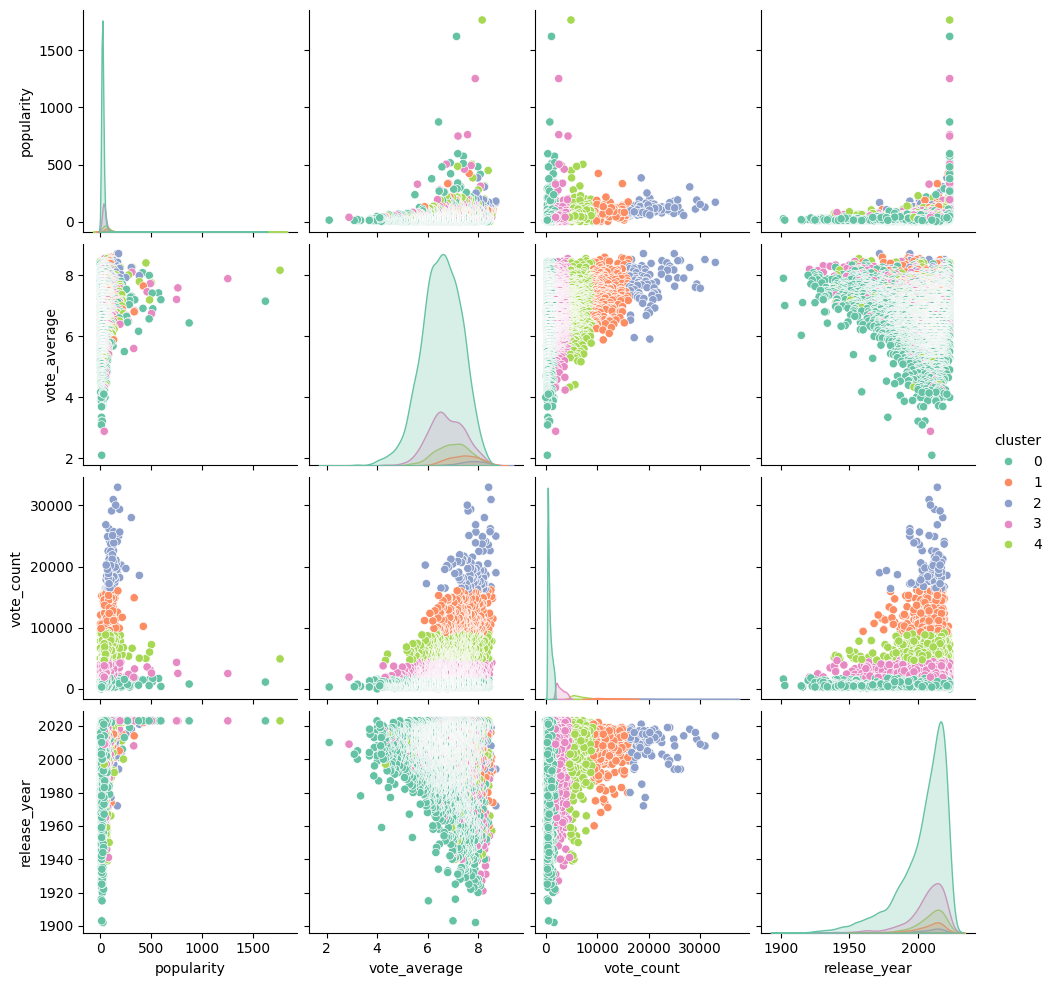

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = predictions.select("popularity", "vote_average", "vote_count", "release_year", "prediction").toPandas()

# Rename prediction column to cluster for better readability
pandas_df.rename(columns={'prediction': 'cluster'}, inplace=True)

# Pairplot
sns.pairplot(pandas_df, hue="cluster", palette="Set2")
plt.show()

23/12/12 00:39:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


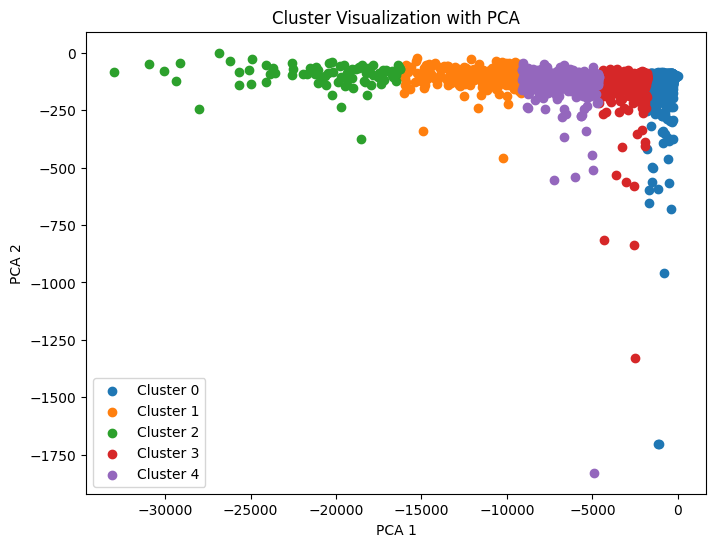

In [3]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import PCA
from pyspark.sql.functions import monotonically_increasing_id

# Assume 'predictions' are the output of KMeans as per the provided code snippet
# Add an ID to join later
predictions = predictions.withColumn("id", monotonically_increasing_id())

# Initialize PCA with the desired number of components, here 2 for 2D visualization
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pcaModel = pca.fit(predictions)

# Transform the data
pcaResult = pcaModel.transform(predictions).select("id", "pcaFeatures")

# Convert to pandas DataFrame for plotting
pandasDF = pcaResult.join(predictions, "id").toPandas()

# Extract PCA features
pandasDF['pca_x'] = pandasDF.pcaFeatures.apply(lambda pcaFeatures: pcaFeatures[0])
pandasDF['pca_y'] = pandasDF.pcaFeatures.apply(lambda pcaFeatures: pcaFeatures[1])

# Plotting
plt.figure(figsize=(8, 6))
for cluster_id in sorted(pandasDF.prediction.unique()):
    cluster = pandasDF[pandasDF.prediction == cluster_id]
    plt.scatter(cluster.pca_x, cluster.pca_y, label=f'Cluster {cluster_id}')
plt.legend()
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('Cluster Visualization with PCA')
plt.show()
